In [29]:
import sys
sys.path.append("./modules")



# Import general modules
from nansat import Nansat, Domain, NSR
import os 
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta

# Import temporal modules needed for testing plotting
import matplotlib.pyplot as plt
#%matplotlib inline

# Import modules for calculate cumulative drift with hourly model data
# Using passive trackers method
from scipy.interpolate import RegularGridInterpolator



# Import SAR forecasting modules
import config
import s1_preparation
import domains_preparation
import SAR1_SAR2_drift_retrivial
import warping_with_domain
import model_data_processing

# Import variables
from config import path_to_HH_files, path_to_HV_files, safe_folder 
from config import output_folder, input_folder
from config import S1_prod_regex, S1_safe_regex
from config import lon, lat, X, Y, proj4, srs
from config import hessian, neighbors
from config import disp_legend_min
from config import disp_legend_max

# For cleaning up memory
import gc

import cProfile
import pstats
from io import StringIO

# For ignoring some warnings
import warnings
# Ignore the runtime warnings related to 'Mean of empty slice' wen calculate rolling average
warnings.filterwarnings('ignore', category=RuntimeWarning, message='Mean of empty slice')

#======================================================================
# 1. Prepare SAR pairs
#----------------------------------------------------------------------

# Collect Sentinel SAFE objects for files in safe directory.
safe_objects = s1_preparation.collect_sentinel_files(safe_folder, path_to_HH_files, path_to_HV_files,  S1_safe_regex, S1_prod_regex)

# Get pairs of Sentinel SAFE objects where their timestamps are within 50 hours of each other.
sar_pairs = s1_preparation.get_pairs_within_time_limit(safe_objects, hours = 50)

# Print details for each pair.
for index, pair in enumerate(sar_pairs, start=1):  # start=1 makes the index start from 1
    print(f'Pair {index}:')
    print(f'SAR1: {pair[0].filename} \ntimestamp: {pair[0].timestamp}\n'
          f'SAR2: {pair[1].filename} \ntimestamp: {pair[1].timestamp}')

#======================================================================
# Loop through pairs for processing
#----------------------------------------------------------------------

# Define mod_dom and dst_dom outside the loop
# Filled up with the first pair domain and stay the same fro all other pairs
# So should be changed if pairs for different areas used
mod_res = 2500
mod_dom = None  # Initialize to None
dst_res = 100
dst_dom = None  # Initialize to None

#Initialize a JohannesroThredds object to interface with the specified THREDDS dataset.
jt = model_data_processing.JohannesroThredds()

# Loop over all pairs and use enumerate to get an index for each pair
for index, pair in enumerate(sar_pairs, start=1):  # start=1 to have human-friendly indexing
    
    # Create a Profile object
    pr = cProfile.Profile()
    pr.enable()  # Start profiling
    
    start_time = time.time()
    
    #======================================================================
    # 2.  Create nansat objects and define model and comparison domains
    #----------------------------------------------------------------------
    
    # 2.1. Prepare nansat objects and domains for HV polarisation
    n1_hv, n2_hv, output_dir_name, plots_dir_hv = domains_preparation.prepare_nansat_objects(
        pair[0], pair[1], output_folder, polarisation='HV')
    
    # Prepare nansat objects and domains for HH polarisation
    n1_hh, n2_hh, output_dir_name, plots_dir_hh = domains_preparation.prepare_nansat_objects(
        pair[0], pair[1], output_folder, polarisation='HH')
    

    # 2.2  Define model domain (mod_dom) for comparing drift and comparison (dst_dom) domain to compare SAR images (real and forecasted)
 
    
    # Check if mod_dom and dst_dom are None, if so, define them based on the first pair
    if mod_dom is None:
        X_subset, Y_subset, lon_subset, lat_subset, min_row, max_row, min_col, max_col = domains_preparation.prepare_grid(n1_hv, n2_hv, srs, X, Y, lon, lat, buffer=0)
        mod_dom = Domain(srs, f'-te {min(X_subset.data)} {min(Y_subset.data) - mod_res * 2} {max(X_subset.data) + mod_res} {max(Y_subset.data)} -tr {mod_res} {mod_res}')
        lon1pm, lat1pm = mod_dom.get_geolocation_grids()
        x, y = mod_dom.get_geolocation_grids(dst_srs=srs)
    
    if dst_dom is None:
        dst_dom = Domain(srs, f'-te {min(X_subset.data)} {min(Y_subset.data) - dst_res * 2} {max(X_subset.data) + dst_res} {max(Y_subset.data)} -tr {dst_res} {dst_res}')

Pair 1:
SAR1: S1A_EW_GRDM_1SDH_20220921T080154_20220921T080258_045100_0563A4_00AB.SAFE 
timestamp: 2022-09-21 08:01:54
SAR2: S1A_EW_GRDM_1SDH_20220923T074534_20220923T074639_045129_0564A5_FE67.SAFE 
timestamp: 2022-09-23 07:45:34
Pair 2:
SAR1: S1A_EW_GRDM_1SDH_20221003T080155_20221003T080259_045275_056983_29A9.SAFE 
timestamp: 2022-10-03 08:01:55
SAR2: S1A_EW_GRDM_1SDH_20221005T074535_20221005T074639_045304_056A88_8BA5.SAFE 
timestamp: 2022-10-05 07:45:35
Pair 3:
SAR1: S1A_EW_GRDM_1SDH_20221015T080155_20221015T080259_045450_056F5F_4931.SAFE 
timestamp: 2022-10-15 08:01:55
SAR2: S1A_EW_GRDM_1SDH_20221017T074535_20221017T074640_045479_057031_AB63.SAFE 
timestamp: 2022-10-17 07:45:35
Pair 4:
SAR1: S1A_EW_GRDM_1SDH_20221027T080155_20221027T080300_045625_05748D_80A7.SAFE 
timestamp: 2022-10-27 08:01:55
SAR2: S1A_EW_GRDM_1SDH_20221029T074535_20221029T074640_045654_057597_EC14.SAFE 
timestamp: 2022-10-29 07:45:35
Pair 5:
SAR1: S1A_EW_GRDM_1SDH_20221108T080155_20221108T080259_045800_057A7E_B07


KeyboardInterrupt



In [33]:
def save_sar_drift_results(output_dir_name, save_name, **kwargs):
    
    # Save final reference drift parameters
    sar_drift_path = os.path.join(output_dir_name, save_name)
    os.makedirs(sar_drift_path, exist_ok=True)    
    
    # Define the path for the .npz file
    save_path = os.path.join(sar_drift_path, f"{save_name}.npz")
    
    # Save the arrays into the .npz file
    np.savez(save_path, **kwargs)
    
    print(f"Arrays saved to {save_path}")
    
    return save_path



In [39]:
save_name = 'domain_output'
sar_drift_output_path = SAR1_SAR2_drift_retrivial.save_sar_drift_results(output_dir_name, save_name,
                                                                         X=X_subset, Y=Y_subset)


Arrays saved to /home/jovyan/experiment_data/2022-2023_48h_experiment/52-82_orbit_2022-2023_batch_output/20220921T080154_20220923T074534/domain_output/domain_output.npz


In [1]:
import sys
sys.path.append("./modules")


In [2]:
# Import general modules
from nansat import Nansat, Domain, NSR
import os 

# Import temporal modules needed for testing plotting
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Import SAR forecasting modules
import config
import s1_preparation
import domains_preparation
import SAR1_SAR2_drift_retrivial
import warping_with_domain

# Import variables
from config import path_to_HH_files, path_to_HV_files, safe_folder 
from config import output_folder, input_folder
from config import S1_prod_regex, S1_safe_regex
from config import lon, lat, X, Y, proj4, srs

# For cleaning up memory
import gc

In [3]:
# 1. Prepare SAR pairs

# Collect Sentinel SAFE objects for files in safe directory.
safe_objects = s1_preparation.collect_sentinel_files(safe_folder, path_to_HH_files, path_to_HV_files,  S1_safe_regex, S1_prod_regex)

# Get pairs of Sentinel SAFE objects where their timestamps are within 50 hours of each other.
sar_pairs = s1_preparation.get_pairs_within_time_limit(safe_objects, hours = 50)

# Print details for each pair.
for index, pair in enumerate(sar_pairs, start=1):  # start=1 makes the index start from 1
    print(f'Pair {index}:')
    print(f'SAR1: {pair[0].filename} \ntimestamp: {pair[0].timestamp}\n'
          f'SAR2: {pair[1].filename} \ntimestamp: {pair[1].timestamp}')

Pair 1:
SAR1: S1A_EW_GRDM_1SDH_20220921T080154_20220921T080258_045100_0563A4_00AB.SAFE 
timestamp: 2022-09-21 08:01:54
SAR2: S1A_EW_GRDM_1SDH_20220923T074534_20220923T074639_045129_0564A5_FE67.SAFE 
timestamp: 2022-09-23 07:45:34
Pair 2:
SAR1: S1A_EW_GRDM_1SDH_20221003T080155_20221003T080259_045275_056983_29A9.SAFE 
timestamp: 2022-10-03 08:01:55
SAR2: S1A_EW_GRDM_1SDH_20221005T074535_20221005T074639_045304_056A88_8BA5.SAFE 
timestamp: 2022-10-05 07:45:35
Pair 3:
SAR1: S1A_EW_GRDM_1SDH_20221015T080155_20221015T080259_045450_056F5F_4931.SAFE 
timestamp: 2022-10-15 08:01:55
SAR2: S1A_EW_GRDM_1SDH_20221017T074535_20221017T074640_045479_057031_AB63.SAFE 
timestamp: 2022-10-17 07:45:35
Pair 4:
SAR1: S1A_EW_GRDM_1SDH_20221027T080155_20221027T080300_045625_05748D_80A7.SAFE 
timestamp: 2022-10-27 08:01:55
SAR2: S1A_EW_GRDM_1SDH_20221029T074535_20221029T074640_045654_057597_EC14.SAFE 
timestamp: 2022-10-29 07:45:35
Pair 5:
SAR1: S1A_EW_GRDM_1SDH_20221108T080155_20221108T080259_045800_057A7E_B07

In [26]:
dir(safe_objects[20])

['HH_tif_filepath',
 'HV_tif_filepath',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'filename',
 'filepath',
 'find_hh_tif_filepath',
 'find_hv_tif_filepath',
 'id',
 'timestamp']

In [9]:
from sea_ice_drift import get_n
from sea_ice_drift.lib import get_spatial_mean, get_uint8_image
def prepare_nansat_objects(sar1, sar2, output_folder, polarisation):
    
    """
    Prepare and plot Nansat objects from given SAR images.
    
    The function creates Nansat objects out of a pair of SAR images and saves a side-by-side visualization of the
    processed images. The generated plots and images are saved to a specified output folder, organized by timestamps 
    and polarisation.

    Parameters:
    - sar1: The first SAR image object with attributes 'safe_filepath' and 'timestamp'.
    - sar2: The second SAR image object with attributes 'safe_filepath' and 'timestamp'.
    - polarisation (optional): The polarisation to be used, either 'HV' or 'HH'.

    Returns:
    - n1: Nansat object of the first SAR image after processing.
    - n2: Nansat object of the second SAR image after processing.
    
    """
    
    f1 = sar1.filepath  
    f2 = sar2.filepath
    
    
    n1 = get_n(f1, bandName= f'sigma0_{polarisation}', remove_spatial_mean=True) 
    n2 = get_n(f2, bandName= f'sigma0_{polarisation}', remove_spatial_mean=True)
    
    
    #Plot
    plt.close('all')
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    
    # Set background color to white
    ax[0].set_facecolor('white')
    ax[1].set_facecolor('white')
    fig.set_facecolor('white')
    
    im1 = ax[0].imshow(n1[1], clim=[0, 255])
    ax[0].axis('off')
    #plt.colorbar(im0, ax=ax[0])
    im2 = ax[1].imshow(n2[1], clim=[0, 255])
    ax[1].axis('off')
    #plt.colorbar(im1, ax=ax[1])
    cax = fig.add_axes([0.92, 0.13, 0.02, 0.75])  # Position and size of the colorbar
    cbar = fig.colorbar(im2, cax=cax)
    #plt.colorbar(im3, ax=ax[2])

    ax[0].set_title(f"SAR1 {polarisation} - {sar1.timestamp.strftime('%Y%m%dT%H%M%S')}")
    ax[1].set_title(f"SAR2 {polarisation} - {sar2.timestamp.strftime('%Y%m%dT%H%M%S')}")



    plt.show()
    plt.close(fig)
  
    return n1, n2 

VMIN:  -4.2604588031768795
VMAX:  6.481118216514579
VMIN:  -3.6825146198272707
VMAX:  5.735837230682371


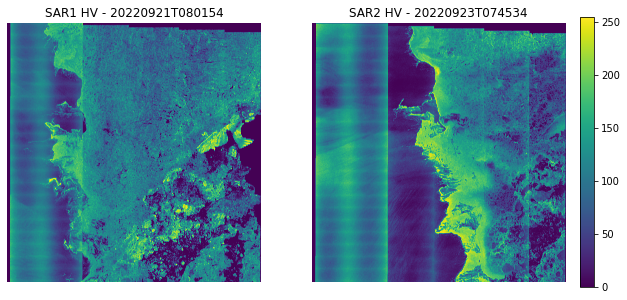

VMIN:  -5.28406229019165
VMAX:  5.342262268066406
VMIN:  -3.5152132987976072
VMAX:  4.821378183364866


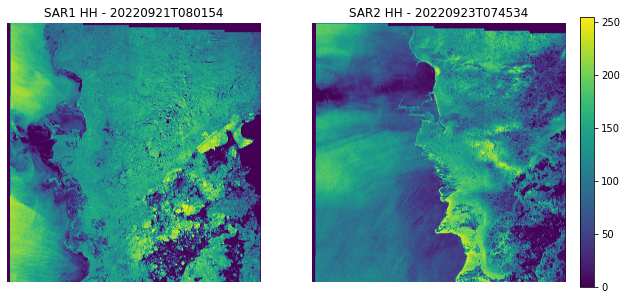

In [10]:
# 2.1. Prepare nansat objects and domains (for each sar pair)

#Prepare nansat objects for HV polarisation
n1_hv, n2_hv = prepare_nansat_objects(sar_pairs[0][0], sar_pairs[0][1], output_folder, polarisation='HV')

#Prepare nansat objects for HH polarisation
n1_hh, n2_hh = prepare_nansat_objects(sar_pairs[0][0], sar_pairs[0][1], output_folder, polarisation='HH')




In [124]:
# 2.2  Define model domain (mod_dom) for comparing drift and comparison (dst_dom) domain to compare SAR images (real and forecasted)

# Prepare subset model grid for domains and pattern matching
X_subset, Y_subset, lon_subset, lat_subset, min_row, max_row, min_col, max_col = domains_preparation.prepare_grid(n1_hv, n2_hv, srs, X, Y, lon, lat, buffer=0)

# Set a model domain
mod_res = 2500
mod_dom = Domain(srs, f'-te {min(X_subset.data)} {min(Y_subset.data) - mod_res * 2} {max(X_subset.data) + mod_res} {max(Y_subset.data)} -tr {mod_res} {mod_res}')


lon1pm, lat1pm = mod_dom.get_geolocation_grids()
x, y = mod_dom.get_geolocation_grids(dst_srs=srs)

# Set a comparison domain 
dst_res = 100
dst_dom = Domain(srs, f'-te {min(X_subset.data)} {min(Y_subset.data) - dst_res * 2} {max(X_subset.data) + dst_res} {max(Y_subset.data)} -tr {dst_res} {dst_res}')

#domains_preparation.plot_borders(mod_dom, n1_hv, n2_hv, output_dir_name) # borders for hh and hv are the same

In [15]:
# Checking that domains have the same borders 

rows1, cols1 = dst_dom.shape()
print("dst_dom corner coordinates:", dst_dom.transform_points([0,cols1-1,0,cols1-1], [0,0,rows1-1,rows1-1], dst_srs=srs))

rows1, cols1 = mod_dom.shape()
print("mod_dom corner coordinates:", mod_dom.transform_points([0,cols1-1,0,cols1-1], [0,0,rows1-1,rows1-1], dst_srs=srs))

dst_dom corner coordinates: (array([278603.1875, 823603.1875, 278603.1875, 823603.1875]), array([774568.375, 774568.375,  69568.375,  69568.375]))
mod_dom corner coordinates: (array([278603.1875, 823603.1875, 278603.1875, 823603.1875]), array([774568.375, 774568.375,  69568.375,  69568.375]))


In [ ]:
def run_feature_tracking(n1, n2, FT=True):  
    
    """
    Execute feature tracking between two SAR images and visualize the results.

    Parameters:
    - n1: The first Nansat object representing a SAR image 1.
    - n2: The second Nansat object representing a SAR image 2.
    - plots_dir: Directory path where the visualizations will be saved.
    - FT: Boolean, if True use feature tracking, otherwise use meshgrid approach.

    Returns:
    - c1, r1: Column and row coordinates of matched keypoints in the first image.
    - c2, r2: Column and row coordinates of matched keypoints in the second image.
    - lon1b, lat1b: Longitude and latitude coordinates of the border of the first image.
    """

    if FT:
        # Feature Tracking Approach
        c1, r1, c2, r2 = feature_tracking(n1, n2, nFeatures=50000, ratio_test=0.6, max_drift=100000, verbose=True)
    else:
        # Meshgrid Approach
        c1, r1 = np.meshgrid(
            np.arange(1, n1.shape()[1], 250),
            np.arange(1, n1.shape()[0], 250))
        c1, r1 = c1.flatten(), r1.flatten()
        lon1ft, lat1ft = n1.transform_points(c1, r1)
        c2, r2 = n2.transform_points(lon1ft, lat1ft, DstToSrc=True)

        margin = 200
        gpi = ((c1 > margin) * (r1 > margin) * (c1 < (n1.shape()[1]-margin)) * (r1 < (n1.shape()[0]-margin)) *
               (c2 > margin) * (r2 > margin) * (c2 < (n2.shape()[1]-margin)) * (r2 < (n2.shape()[0]-margin)))

        c1, r1, c2, r2 = c1[gpi], r1[gpi], c2[gpi], r2[gpi]
        return c1, r1, c2, r2

In [123]:
from sea_ice_drift.ftlib import feature_tracking
sys.path.append(r'./modules/sea_ice_drift')
from pmlib_with_ssim import pattern_matching

# 3.   Retrieve reference drift
# 3.1. Run feature tracking and pattern matching for HV

# Run feature tracking and plot results 
c1_hv, r1_hv, c2_hv, r2_hv = run_feature_tracking(n2_hv, n2_hv, FT= False)

#Run pattern matching and plot results
upm_hv, vpm_hv, apm_hv, rpm_hv, hpm_hv, ssim_hv, lon2pm_hv, lat2pm_hv = pattern_matching(lon1pm, lat1pm, n1_hv, c1_hv, r1_hv, n2_hv, c2_hv, r2_hv, srs, 
                                                           min_border=200,
                                                           max_border=200,
                                                           #min_border=10, #test
                                                           #max_border=10, #test
                                                           #angles=[-9,-6, -3, 0, 3, 6, 9]) #test
                                                           angles=[-50, -45, -40, -35, -30, -25, -20, -15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15, 20, 25, 30, 35, 40, 45, 50])

TypeError: unsupported operand type(s) for -: 'float' and 'NSR'

In [11]:
# 3.2. Run feature tracking and pattern matching for HH

# HH Processing
# Run feature tracking and plot results 
c1_hh, r1_hh, c2_hh, r2_hh = SAR1_SAR2_drift_retrivial.run_feature_tracking(n2_hh, n2_hh, plots_dir_hh, FT= False)

#Run pattern matching and plot results
upm_hh, vpm_hh, apm_hh, rpm_hh, hpm_hh, ssim_hh, lon2pm_hh, lat2pm_hh = SAR1_SAR2_drift_retrivial.run_pattern_matching(plots_dir_hh, x, y, 
                                                           lon1pm, lat1pm, n1_hh, c1_hh, r1_hh, n2_hh, c2_hh, r2_hh,srs, 
                                                           min_border=200,
                                                           max_border=200,
                                                           #min_border=10, #test
                                                           #max_border=10, #test
                                                           #angles=[-9,-6, -3, 0, 3, 6, 9]) #test
                                                           angles=[-50, -40, -35, -30, -25, -20, -15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15, 20, 25, 30, 35, 40, 50 ])

Key points found: 50000
Key points found: 50000
Domain filter: 50000 -> 43258
Domain filter: 50000 -> 48486
Keypoints matched 4.317245721817017
Ratio test 0.600000 found 489 keypoints
MaxDrift filter: 489 -> 489
LSTSQ filter: 489 -> 481


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


85% 02551.3 04250.4 03534.0 04466.0 +09.0 0.53 15.77 0.4398% 01837.9 04844.5 02841.0 05223.0 +12.0 0.34 7.49 0.1789% 02838.1 04475.1 03929.0 04638.0 +30.0 0.27 4.60 0.17
 Pattern matching - OK! (413 sec)


In [19]:
# 3.3. Get combined drift and all textural parameters

# Combining hh and hv results based on hessian threshold
upm, vpm, apm, rpm, hpm, ssim, lon2pm, lat2pm = SAR1_SAR2_drift_retrivial.combine_hh_hv(output_dir_name, x, y, upm_hh, vpm_hh, apm_hh, rpm_hh, hpm_hh, ssim_hh, lon2pm_hh, lat2pm_hh,
                              upm_hv, vpm_hv, apm_hv, rpm_hv, hpm_hv, ssim_hv, lon2pm_hv, lat2pm_hv)

In [13]:
# 3.4.  Get good pixel indices based on hessian and neighbor thresholds.

#Returns:
#    - gpi1: Good pixel index based on hessian value
#    - gpi2: Good pixel index combining hessian and neighbors count 

hessian=8
neighbors=2

gpi1, gpi2 = SAR1_SAR2_drift_retrivial.get_good_pixel_indices(hpm, h_threshold=hessian, neighbors_threshold=neighbors)

    
# Plot the filtering results
general_plots_path = SAR1_SAR2_drift_retrivial.plot_filter_results(output_dir_name, x, y, hpm, upm, vpm, gpi1, gpi2, hessian, neighbors)


#  Save final drift, its parameters and filtering arrays to npy files
save_name = 'sar_drift_output'
sar_drift_output_path = SAR1_SAR2_drift_retrivial.save_sar_drift_results(output_dir_name, save_name,
                                                                         upm=upm, vpm=vpm, apm=apm, rpm=rpm, 
                                                                         hpm=hpm, ssim=ssim, lon2pm=lon2pm, 
                                                                         lat2pm=lat2pm, gpi1=gpi1, gpi2=gpi2)

Arrays saved to /home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output/20230212T080151_20230214T074531/sar_ref_drift_output/sar_ref_drift_output.npz


In [ ]:
general_plots_path = SAR1_SAR2_drift_retrivial.plot_filter_results(output_dir_name, x, y, hpm, upm, vpm, gpi1, gpi2, hessian, neighbors)


NameError: name 'general_plots_path' is not defined

In [12]:
# Extract results arrays

# Define the path to the parent directory
parent_dir = '/home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output'

# Check if the 'sar_drift_forecast_quality.npz' file exists
npz_file_path = os.path.join(parent_dir,'20230212T080151_20230214T074531', 'sar_drift_output', 'sar_drift_output.npz')
if os.path.exists(npz_file_path):
    # Load the contents of the .npz file
    npz_sar_data = np.load(npz_file_path)
    
    upm = npz_sar_data['upm']
    vpm = npz_sar_data['vpm']
    hpm = npz_sar_data['hpm']
    gpi1 = npz_sar_data['gpi1']
    gpi2 = npz_sar_data['gpi2']
    lon2pm = npz_sar_data['lon2pm']
    lat2pm = npz_sar_data['lat2pm']

#general_plots_path = '/home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output/20230212T080151_20230214T074531/General_plots'

In [16]:
# 4. Warp SAR1 image with the reference sar drift and compare all arrays in the comparison distination domain

# 4.1. Warp
# Warp SAR1 with SAR-drift compenstaion/displacement
good_pixels = gpi2
mask_pm = ~good_pixels # mask out low quality or NaN
s1_dst_dom_S_hv = warping_with_domain.warp_with_uv(n1_hv, n1_hv[1], mod_dom, upm, vpm, mask_pm, dst_dom)
s1_dst_dom_S_hh = warping_with_domain.warp_with_uv(n1_hh, n1_hh[1], mod_dom, upm, vpm, mask_pm, dst_dom)

# Warp SAR2 to the comparison domain
s2_dst_dom_hv = warping_with_domain.warp(n2_hv, n2_hv[1], dst_dom)
s2_dst_dom_hh = warping_with_domain.warp(n2_hh, n2_hh[1], dst_dom)

# Warp SAR1 to the comparison domain for visualisation
s1_dst_dom_hv = warping_with_domain.warp(n1_hv, n1_hv[1], dst_dom)
s1_dst_dom_hh = warping_with_domain.warp(n1_hh, n1_hh[1], dst_dom)

In [25]:
x,y = np.meshgrid(X, Y)

In [34]:
import gc


def normalize(array):
    """Normalize an array to the range [0, 1]."""
    array_min = array.min()
    array_max = array.max()
    return (array - array_min) / (array_max - array_min)

def gamma_correction(image, gamma):
    """Apply gamma correction to an image."""
    return image ** (1.0 / gamma)

def plot_sar_forecast_images(s1_dst_dom_hv, s2_dst_dom_hv, s1_dst_dom_S_hv, s1_dst_dom_hh, s2_dst_dom_hh, s1_dst_dom_S_hh, hpm, gpi2,x,y, gamma_value=1.2):
    """
    Plot and save SAR forecast images.

    Parameters:
    - general_save_path: Path to save the images.
    - file_name: The base name for the saved files.
    - s1_dst_dom_hv, s2_dst_dom_hv, s1_dst_dom_S_hv, s1_dst_dom_hh, s2_dst_dom_hh, s1_dst_dom_S_hh: Arrays representing different channels of SAR data for SAR1, SAR2 and SAR2_forecasted.
    - gamma_value: The gamma correction value; defaults to 1.2.
    """
    # Normalize and apply gamma correction
    s1_hv_gamma_corrected = gamma_correction(normalize(s1_dst_dom_hv), gamma_value)
    s2_hv_gamma_corrected = gamma_correction(normalize(s2_dst_dom_hv), gamma_value)
    s1_predicted_hv_gamma_corrected = gamma_correction(normalize(s1_dst_dom_S_hv), gamma_value)
    s1_hh_gamma_corrected = gamma_correction(normalize(s1_dst_dom_hh), gamma_value)
    s2_hh_gamma_corrected = gamma_correction(normalize(s2_dst_dom_hh), gamma_value)
    s1_predicted_hh_gamma_corrected = gamma_correction(normalize(s1_dst_dom_S_hh), gamma_value)

    # Create an empty blue channel
    blue_channel1 = np.zeros_like(s1_hv_gamma_corrected)
    blue_channel2 = np.zeros_like(s2_hv_gamma_corrected)
    blue_channel3 = np.zeros_like(s1_predicted_hv_gamma_corrected)

    # Stack the channels to make composite RGB images
    rgb_image1 = np.stack([s1_hv_gamma_corrected, s1_hh_gamma_corrected, blue_channel1], axis=-1)
    rgb_image2 = np.stack([s2_hv_gamma_corrected, s2_hh_gamma_corrected, blue_channel2], axis=-1)
    rgb_image3 = np.stack([s1_predicted_hv_gamma_corrected, s1_predicted_hh_gamma_corrected, blue_channel3], axis=-1)

    # Memory cleanup
    del s1_hv_gamma_corrected, s2_hv_gamma_corrected, s1_predicted_hv_gamma_corrected
    del s1_hh_gamma_corrected, s2_hh_gamma_corrected, s1_predicted_hh_gamma_corrected
    del blue_channel1, blue_channel2, blue_channel3
    gc.collect()

    # Display the composite images
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(rgb_image1)
    #filtered_hpm = np.where(hpm > threshold, hpm, np.nan)
    axs[0].imshow(hpm, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='PiYG', alpha=1, vmin=0, vmax=15)
    axs[1].imshow(rgb_image3)
    axs[2].imshow(rgb_image2)
    axs[0].set_title('SAR1')
    axs[1].set_title('SAR2 Predicted')
    axs[2].set_title('SAR2')

    # Set common limits for all subplots and background color to white
    for ax in axs:
        ax.set_xlim([0, 3200])
        ax.set_ylim([6100, 1700])
        ax.set_facecolor('white')

    fig.set_facecolor('white')
    plt.tight_layout()
    #plt.show()

    # Save the figure
    #save_path = os.path.join(general_save_path, f"{file_name}.png")
    #fig.savefig(save_path, dpi=300, bbox_inches='tight')
    
    del rgb_image1, rgb_image2, rgb_image3
    gc.collect()
    plt.show()
    plt.close(fig)

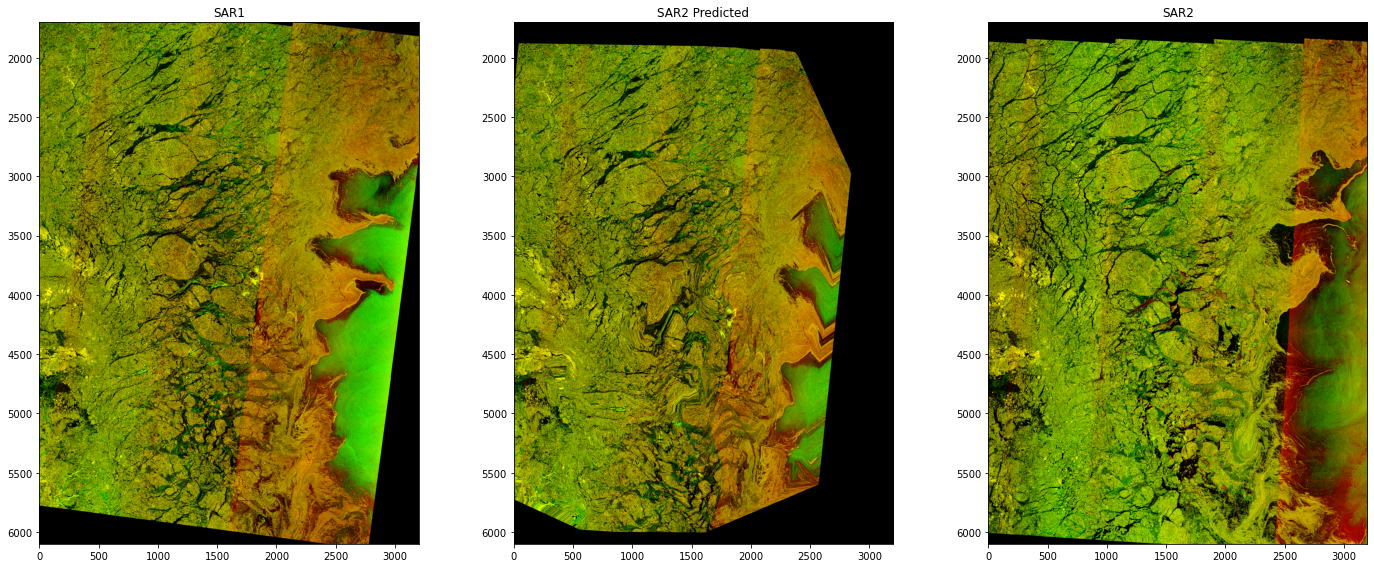

In [41]:
# 4.2. Plot warping results


plot_sar_forecast_images(s1_dst_dom_hv, s2_dst_dom_hv, s1_dst_dom_S_hv,
                         s1_dst_dom_hh, s2_dst_dom_hh, s1_dst_dom_S_hh, hpm, gpi2,x,y,
                         gamma_value=1.2)

In [14]:
# 5. Calculate quality parametrs (corr, hess, ssim) for the predicted SAR2 (by calculating pattern matchin on SAR2 and SAR2_predicted)

# 5.1. Make new nansat objects for comparison

n_s1_predict = Nansat.from_domain(dst_dom, array = s1_dst_dom_S_hv)
n_s2 = Nansat.from_domain(dst_dom, array = s2_dst_dom_hv)

# 5.2. Create directory for saving plots 
comparison_dir = os.path.join(output_dir_name, f"SAR_distort_error_plots")
try:
    os.makedirs(comparison_dir, exist_ok=True)
    print(f"Successfully created {comparison_dir}")
except Exception as e:
    print(f"Failed to create {comparison_dir}. Error: {e}")
    
# Calculate realibility indexes 

# 5.4. Run feature tracking and plot results 
c1_alg_hv, r1_alg_hv, c2_alg_hv, r2_alg_hv = SAR1_SAR2_drift_retrivial.run_feature_tracking(n_s1_predict, n_s2, comparison_dir)

# 5.5. Run pattern matching and plot results
upm_alg_hv, vpm_alg_hv, apm_alg_hv, rpm_alg_hv, hpm_alg_hv, ssim_alg_hv, lon2pm_alg_hv, lat2pm_alg_hv = SAR1_SAR2_drift_retrivial.run_pattern_matching(comparison_dir, x, y, 
                                                           lon1pm, lat1pm, n_s1_predict, c1_alg_hv, r1_alg_hv, n_s2, c2_alg_hv, r2_alg_hv, srs, 
                                                           min_border=200,
                                                           max_border=200,
                                                           #min_border=10, #test
                                                           #max_border=10, #test
                                                           #angles=[-9,-6, -3, 0, 3, 6, 9]) #test
                                                           angles=[-50, -45, -40, -35, -30, -25, -20, -15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15, 20, 25, 30, 35, 40, 45, 50])


# 5.6. Save comparison results, its parameters and filtering arrays to npy files
save_name = 'sar_distort_error_data'
sar_drift_output_path = SAR1_SAR2_drift_retrivial.save_sar_drift_results(output_dir_name, save_name,
                                                                         upm=upm_alg_hv, vpm=vpm_alg_hv, apm=apm_alg_hv, rpm=rpm_alg_hv, 
                                                                         hpm=hpm_alg_hv, ssim=ssim_alg_hv, lon2pm=lon2pm_alg_hv, 
                                                                         lat2pm=lat2pm_alg_hv, gpi1=gpi1, gpi2=gpi2))